<a href="https://colab.research.google.com/github/buck8bunny/NLP/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import requests
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords

url = 'https://raw.githubusercontent.com/olegdubetcky/Ukrainian-Stopwords/main/ukrainian'
r = requests.get(url)
with open(nltk.data.path[0]+'/corpora/stopwords/ukrainian', 'wb') as f:
    f.write(r.content)
# Retrieve HTTP meta-data
print(r.status_code)
print(r.headers['content-type'])
print(r.encoding)

stopwords = stopwords.words("ukrainian")
!pip install git+https://github.com/kmike/pymorphy2.git
!pip install -U pymorphy2-dicts-uk
!pip install pyLDAvis
!pip install joblib
import pymorphy2
morph = pymorphy2.MorphAnalyzer(lang='uk')
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
import joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.lda_model
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


200
text/plain; charset=utf-8
utf-8
  Cloning https://github.com/kmike/pymorphy2.git to /tmp/pip-req-build-zfx1fitu
  Running command git clone --filter=blob:none --quiet https://github.com/kmike/pymorphy2.git /tmp/pip-req-build-zfx1fitu
  Resolved https://github.com/kmike/pymorphy2.git to commit 92d546f042ff14601376d3646242908d5ab786c1
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspe

In [51]:
# Створюю датафрейм, з власноруч спарсених даних з тсн
df = pd.read_csv('https://raw.githubusercontent.com/buck8bunny/NLP/refs/heads/main/news_data.csv', encoding='utf8')
df.category.unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Війна', 'Проспорт', 'Укрaїнa', 'Різне', 'Гламур', 'Світ', 'Київ',
       'Наука та IT', 'Політика', 'Гроші', 'Астрологія',
       'Консервація і варення', 'Корисні статті', 'Цікaвинки', 'Здоров’я',
       'Львів', 'Зброя'], dtype=object)

In [52]:
stop_words = frozenset(stopwords+list(string.punctuation)+[u'quot'])
for index, row in df.iterrows():
  sentences = nltk.sent_tokenize(row['title'].lower())
  for sentence in sentences:
    words = nltk.word_tokenize(sentence)
    without_stop_words = [word for word in words if not word in stop_words]

    normal_words=[]
    for token in without_stop_words:
      p = morph.parse(token)[0]
      normal_words.append(p.normal_form)
    n_title = ' '.join(normal_words)
    df.loc[index, 'normalized'] =n_title

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
#розділення даних на зразки для навчання та тестування
train_docs, test_docs = train_test_split(df, stratify=df.category, test_size=50, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
train_docs.shape, test_docs.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


((1655, 4), (50, 4))

In [55]:
pd.Series(test_docs.category).value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,count
category,
Укрaїнa,15
Війна,7
Світ,6
Гламур,4
Різне,4
Політика,3
Київ,2
Проспорт,2
Цікaвинки,2


In [57]:
vectorizer = TfidfVectorizer(max_df=.2, min_df=3, max_features=2000)
doc_train_matrix = vectorizer.fit_transform(train_docs['normalized'])
words = vectorizer.get_feature_names_out()
doc_train_matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<1655x1144 sparse matrix of type '<class 'numpy.float64'>'
	with 10520 stored elements in Compressed Sparse Row format>

In [58]:
doc_test_matrix = vectorizer.transform(test_docs['normalized'])
doc_test_matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<50x1144 sparse matrix of type '<class 'numpy.float64'>'
	with 274 stored elements in Compressed Sparse Row format>

In [59]:
topic_labels = ['Тема {}'.format(i) for i in range(1, 9)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
lda = LatentDirichletAllocation(n_components=8, n_jobs=-1, max_iter=500,
                                learning_method='batch', evaluate_every=5,
                                verbose=1, random_state=42)
lda.fit(doc_train_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 4951.7697
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 4647.8812
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 4594.5824
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 4572.8737
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 4568.3309
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(evaluate_every=5, max_iter=500, n_components=8,
                          n_jobs=-1, random_state=42, verbose=1)

In [61]:
joblib.dump(lda, 'lda_500_iter.pkl')
lda = joblib.load('lda_500_iter.pkl')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
#Досліджуємо теми та розподіл слів
topics_count = lda.components_
print(topics_count.shape)
topics_count[:8]

(8, 1144)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.12503975, 0.50156764, 0.12500024, ..., 1.26758122, 0.12501016,
        3.14948612],
       [0.12500619, 0.71470452, 1.48225534, ..., 0.12500061, 0.12500012,
        0.12500025],
       [0.12508273, 0.12500024, 0.12508306, ..., 0.59498831, 0.12512202,
        0.54926391],
       ...,
       [2.64430701, 0.12501315, 0.12704862, ..., 0.12500061, 4.1571596 ,
        0.12624711],
       [0.12509208, 0.1250815 , 0.12500035, ..., 0.57132429, 0.12507459,
        0.12500032],
       [0.95888141, 1.91672051, 0.12500021, ..., 0.54065135, 0.12502643,
        0.96294585]])

In [64]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8
10,0.000160,0.000186,0.000247,0.000222,0.001156,0.003917,0.000231,0.001102
100,0.000641,0.001064,0.000247,0.000222,0.000223,0.000185,0.000231,0.002203
11,0.000160,0.002207,0.000247,0.000222,0.000223,0.000188,0.000231,0.000144
12,0.000160,0.001116,0.001036,0.000222,0.000912,0.002252,0.002474,0.000144
13,0.000160,0.000187,0.000248,0.000222,0.001713,0.001389,0.003788,0.000144


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


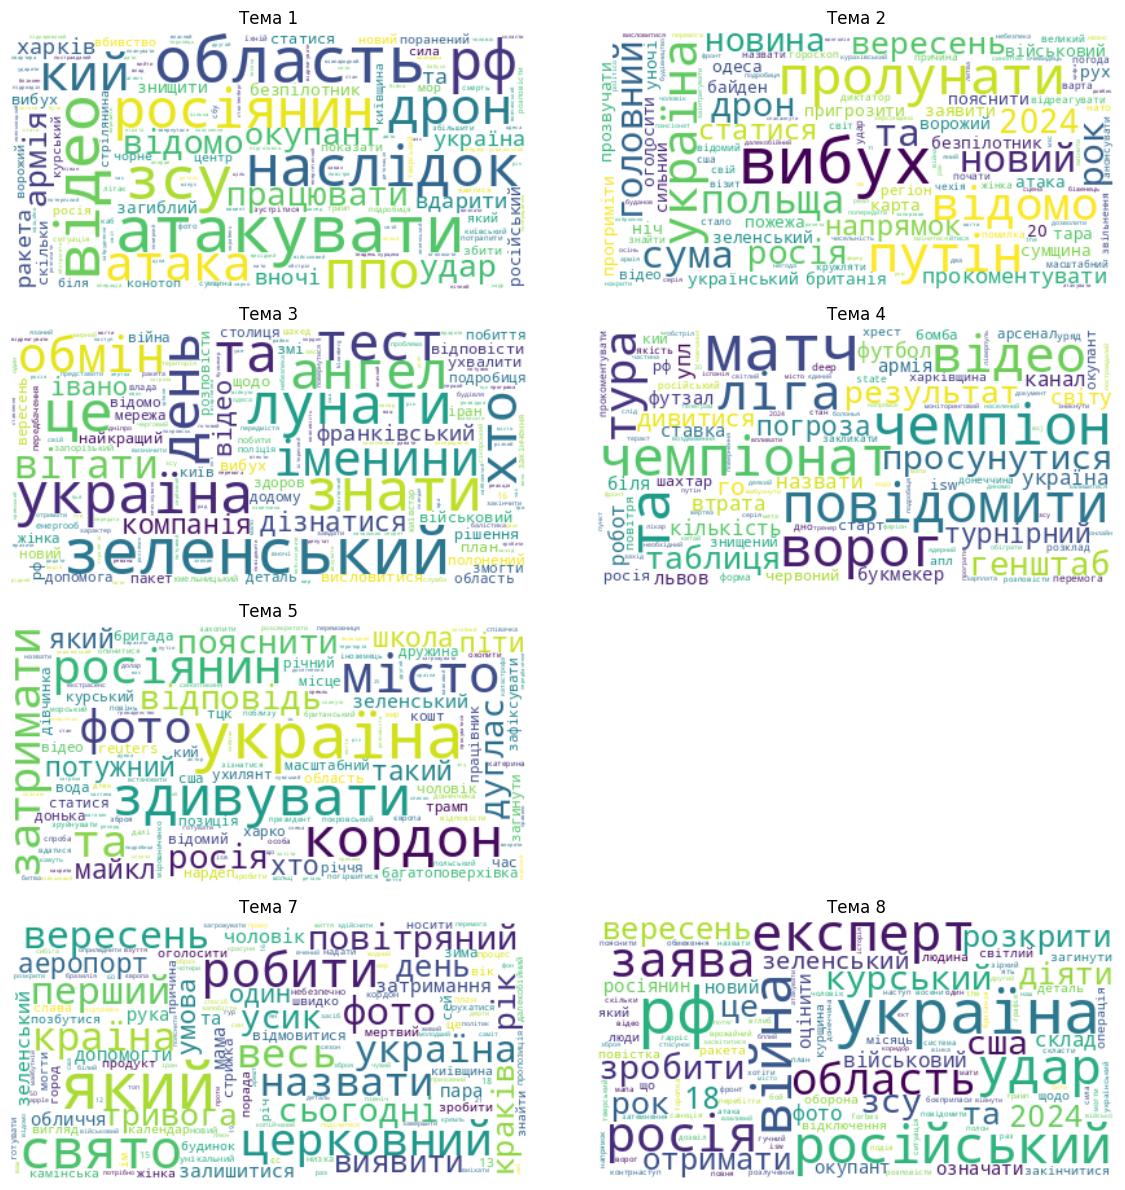

In [65]:
w = WordCloud(background_color='white',max_font_size = 50)
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(12, 12))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=12)
    axes[t].axis('off')
axes[5].set_visible(False)
plt.tight_layout()

In [66]:
# всі слова мають позитивну ймовірність для всіх тем
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [68]:
#найпопулярніші слова у темах
n_words = 12
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(n_words).index.tolist()
pd.DataFrame(top_words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8
0,область,вибух,зеленський,матч,україна,річний,який,рф
1,атакувати,пролунати,знати,та,здивувати,рок,свято,україна
2,відео,путін,це,чемпіон,кордон,та,робити,війна
3,зсу,україна,лунати,повідомити,місто,2024,церковний,експерт
4,наслідок,відомо,україна,ворог,росіянин,скільки,назвати,російський
5,рф,польща,день,чемпіонат,та,фото,весь,удар
6,росіянин,сума,та,ліга,фото,долар,країна,росія
7,ппо,та,тест,відео,затримати,вересень,фото,заява
8,дрон,новий,хто,тура,відповідь,показати,перший,область
9,кий,головний,ангел,просунутися,пояснити,час,вересень,зробити


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

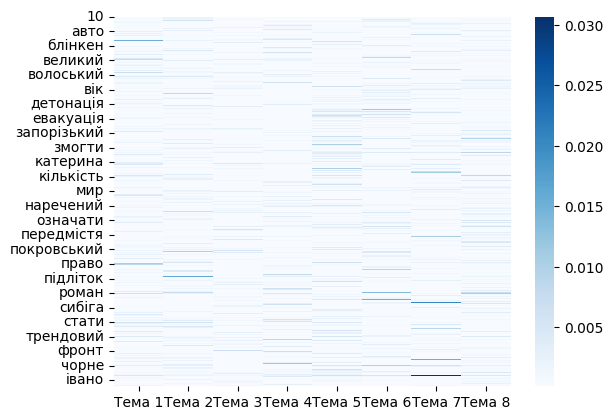

In [69]:
sns.heatmap(topics, cmap='Blues')

In [70]:
train_preds = lda.transform(doc_train_matrix)
train_preds.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1655, 8)

In [71]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.category)
train_eval.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8
category,,,,,,,,
Київ,0.039205,0.370573,0.039116,0.039143,0.394618,0.039121,0.039110,0.039115
Світ,0.737913,0.037963,0.037319,0.037403,0.037389,0.037324,0.037310,0.037378
Гламур,0.036957,0.036377,0.036392,0.036389,0.036381,0.294965,0.036400,0.486139
Цікaвинки,0.673952,0.046565,0.046602,0.046611,0.046566,0.046560,0.046579,0.046564
Укрaїнa,0.052171,0.052215,0.634729,0.052162,0.052185,0.052165,0.052189,0.052184


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


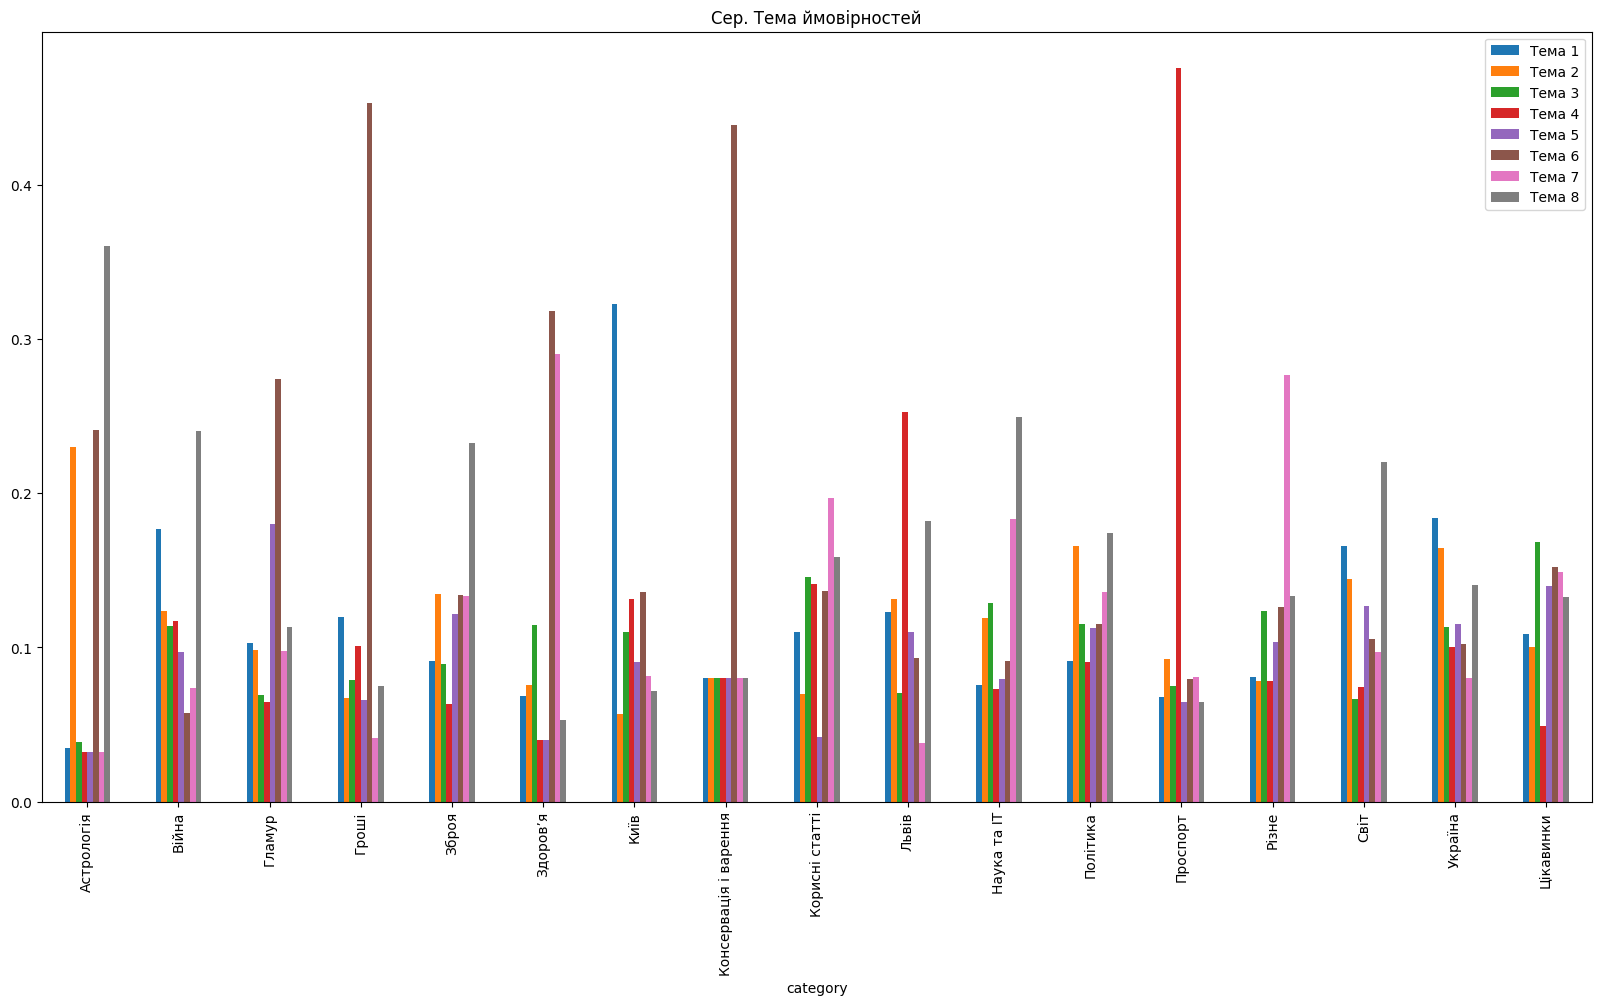

In [74]:
# відображення того, як перетинаються теми і категорії
train_eval.groupby(level='category').mean().plot.bar(title='Сер. Тема ймовірностей', figsize=(20,10));

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-75-3ecb1cac0f4e>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='category').idxmax(


Text(0.5, 1.0, 'Дані навчання: Тематичні завдання')

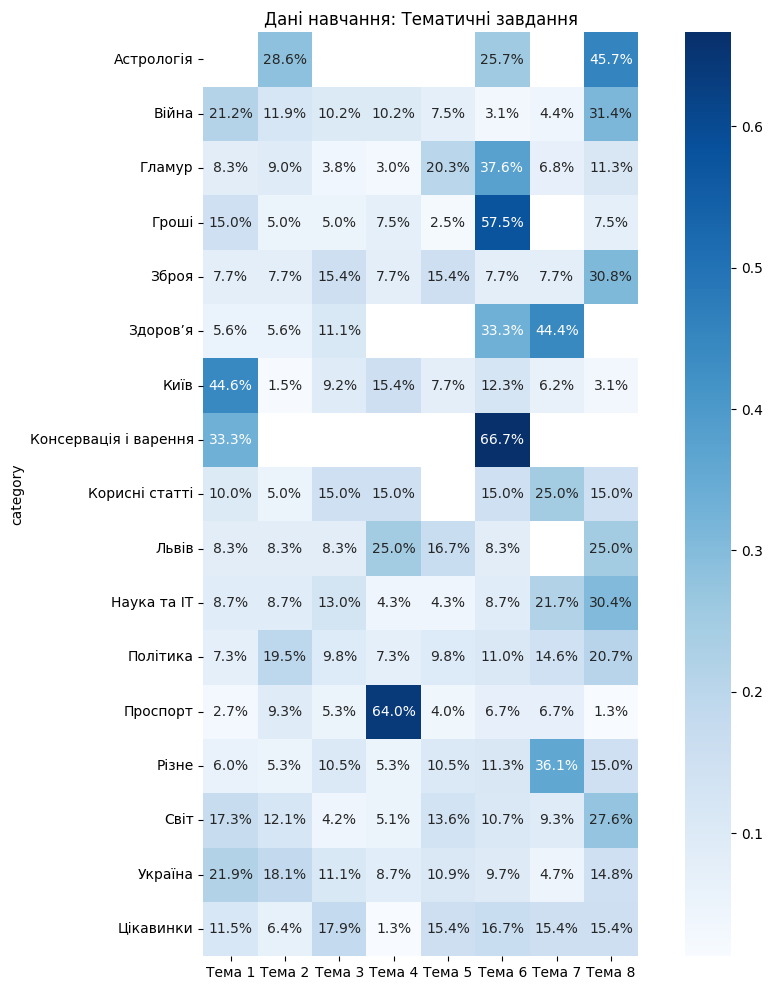

In [75]:
df = train_eval.groupby(level='category').idxmax(
    axis=1).reset_index(-1, drop=True)
plt.figure(figsize=(12, 12))
sns.heatmap(df.groupby(level='category').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Дані навчання: Тематичні завдання')

In [76]:
train_eval = pd.DataFrame(data=lda.transform(doc_train_matrix),
                          columns=topic_labels,
                          index=train_docs.category)
test_eval = pd.DataFrame(data=lda.transform(doc_test_matrix),
                         columns=topic_labels,
                         index=test_docs.category)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-77-9bb13f9f6eec>:4: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = df.groupby(level='category').idxmax(
<ipython-input-77-9bb13f9f6eec>:4: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = df.groupby(level='category').idxmax(


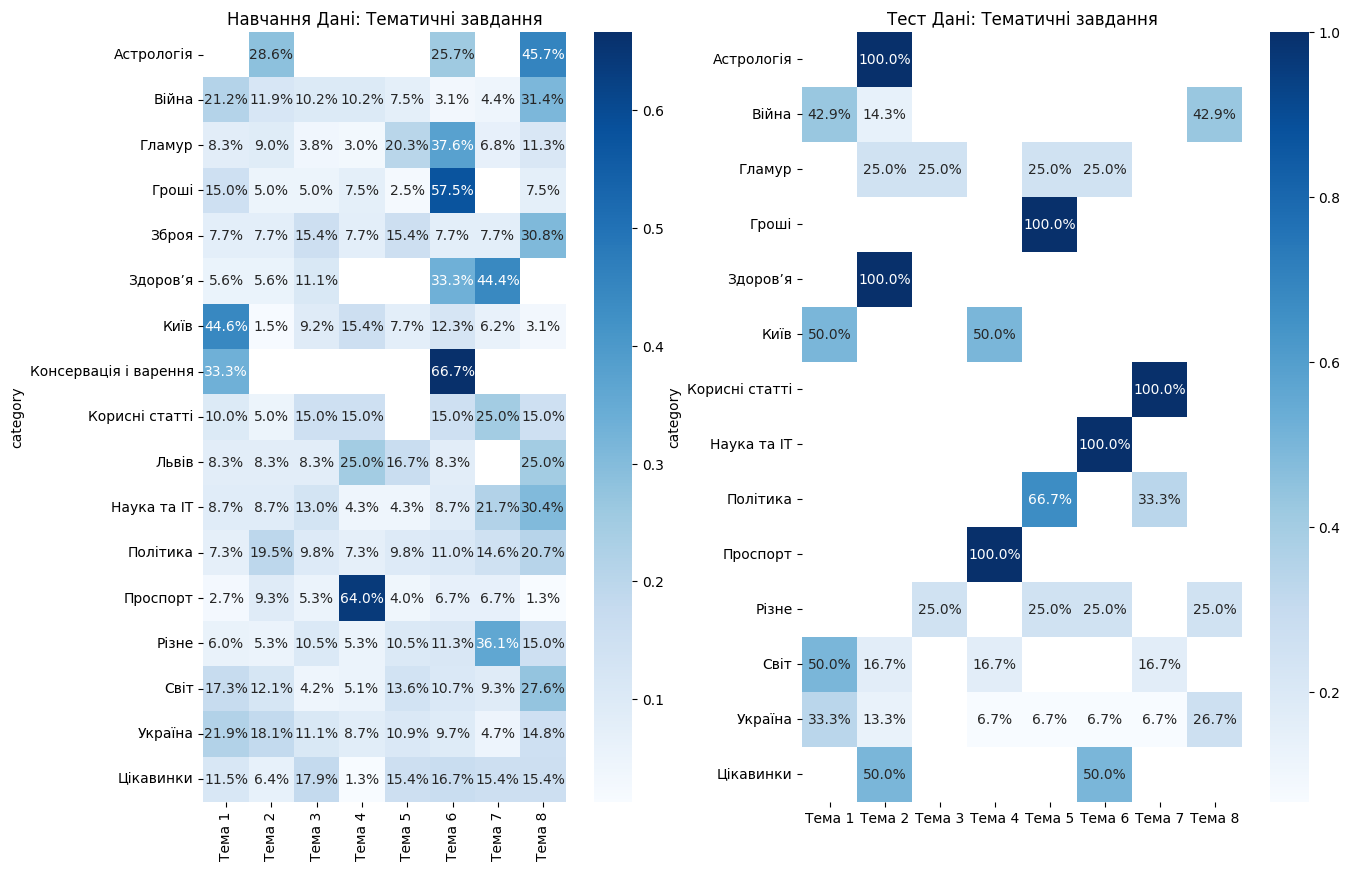

In [77]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))
source = ['Навчання', 'Тест']
for i, df in enumerate([train_eval, test_eval]):
    df = df.groupby(level='category').idxmax(
    axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='category').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Дані: Тематичні завдання'.format(source[i]));

In [78]:
#Неправильно класифіковані статті
test_assignments = test_eval.groupby(level='category').idxmax(
    axis=1).reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['title'] = test_docs.title.values
test_assignments.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-78-da6f465b3926>:2: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = test_eval.groupby(level='category').idxmax(


,category,predicted,title
0,Астрологія,Тема 2,Україна потерпає від дефіциту робочої сили: на...
1,Війна,Тема 8,"Названо сім звичок, від яких потрібно відмовит..."
2,Війна,Тема 1,Київ задихається від диму: як захиститися від ...
3,Війна,Тема 8,РФ влучила в об'єкти інфраструктури на Чернігі...
4,Війна,Тема 8,"""Піхота майже безкінечна"": військовий розповів..."


In [79]:
misclassified = test_assignments[(test_assignments.category == 'Політика') & (
    test_assignments.predicted == 'Тема 1')]
misclassified.title

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,title


In [80]:
misclassified.title.tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[]

In [81]:
lda_viz = pyLDAvis.lda_model.prepare(lda, doc_train_matrix, vectorizer, mds='tsne')
pyLDAvis.display(lda_viz)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
